# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K
from numpy import mean
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Reading Dataset

In [2]:
df = pd.read_csv("Dataset_all.csv")
df

,Lattice Type,X,Y,Z,Thickness,Force (N),Strain (mm)
0,SplitP,10.0,8.7,9.5,1.1,0.2190,0.0001
1,SplitP,10.0,8.7,9.5,1.1,0.2675,0.0023
2,SplitP,10.0,8.7,9.5,1.1,0.3566,0.0111
3,SplitP,10.0,8.7,9.5,1.1,0.2351,0.0255
4,SplitP,10.0,8.7,9.5,1.1,0.3353,0.0407
...,...,...,...,...,...,...,...
76756,Lidinoid,8.3,7.8,6.1,0.7,1267.1747,11.3756
76757,Lidinoid,8.3,7.8,6.1,0.7,1267.6182,11.3923
76758,Lidinoid,8.3,7.8,6.1,0.7,1268.4763,11.4090
76759,Lidinoid,8.3,7.8,6.1,0.7,1269.4996,11.4256


# Normalize Dataset using RIN

In [3]:
def rank_and_normalize(series):
    ranked_series = series.rank()
    normalized_series = (ranked_series - 0.5) / len(series)
    result = norm.ppf(normalized_series)
    return result

columns_to_normalize = ['X', 'Y', 'Z', 'Thickness', 'Force (N)', 'Strain (mm)']
for column in columns_to_normalize:
    df[column] = rank_and_normalize(df[column])
df

,Lattice Type,X,Y,Z,Thickness,Force (N),Strain (mm)
0,SplitP,2.304713,0.806729,1.516002,0.014924,-2.549112,-3.236146
1,SplitP,2.304713,0.806729,1.516002,0.014924,-2.479119,-2.871088
2,SplitP,2.304713,0.806729,1.516002,0.014924,-2.394080,-2.715482
3,SplitP,2.304713,0.806729,1.516002,0.014924,-2.523859,-2.609514
4,SplitP,2.304713,0.806729,1.516002,0.014924,-2.414051,-2.532233
...,...,...,...,...,...,...,...
76756,Lidinoid,0.208935,0.226942,-0.708049,-0.819751,1.362283,0.907819
76757,Lidinoid,0.208935,0.226942,-0.708049,-0.819751,1.362572,0.911870
76758,Lidinoid,0.208935,0.226942,-0.708049,-0.819751,1.363398,0.915836
76759,Lidinoid,0.208935,0.226942,-0.708049,-0.819751,1.364143,0.919817


# Converting Lattice Type Variable to Numerical

In [4]:
le = preprocessing.LabelEncoder()
df['Lattice Type'] = le.fit_transform(df['Lattice Type'])
df

,Lattice Type,X,Y,Z,Thickness,Force (N),Strain (mm)
0,4,2.304713,0.806729,1.516002,0.014924,-2.549112,-3.236146
1,4,2.304713,0.806729,1.516002,0.014924,-2.479119,-2.871088
2,4,2.304713,0.806729,1.516002,0.014924,-2.394080,-2.715482
3,4,2.304713,0.806729,1.516002,0.014924,-2.523859,-2.609514
4,4,2.304713,0.806729,1.516002,0.014924,-2.414051,-2.532233
...,...,...,...,...,...,...,...
76756,2,0.208935,0.226942,-0.708049,-0.819751,1.362283,0.907819
76757,2,0.208935,0.226942,-0.708049,-0.819751,1.362572,0.911870
76758,2,0.208935,0.226942,-0.708049,-0.819751,1.363398,0.915836
76759,2,0.208935,0.226942,-0.708049,-0.819751,1.364143,0.919817


# Defining Features and Targets

In [5]:
x = df[['Lattice Type', 'Force (N)', 'Strain (mm)']]
y = df[['X', 'Y', 'Z', 'Thickness']]
x

,Lattice Type,Force (N),Strain (mm)
0,4,-2.549112,-3.236146
1,4,-2.479119,-2.871088
2,4,-2.394080,-2.715482
3,4,-2.523859,-2.609514
4,4,-2.414051,-2.532233
...,...,...,...
76756,2,1.362283,0.907819
76757,2,1.362572,0.911870
76758,2,1.363398,0.915836
76759,2,1.364143,0.919817


# Splitting to Train and Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)

# Hyperparameters using GridSearchCV 

In [61]:
def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

def create_model(activation):
    model = Sequential()
    model.add(Dense(units=90, input_dim=3, activation=activation))
    model.add(Dropout(rate=0.1))
    model.add(Dense(4, activation='tanh'))
    model.compile(loss='mean_squared_error',
                            optimizer='RMSprop',
                            metrics=['MeanSquaredError', r2_score])
    return model

params = {'optimizer__learning_rate': [0.01, 0.05, 0.1],
              'model__activation': ['softmax', 'sigmoid', 'hard_sigmoid'],
              'batch_size': [30, 90],
              'epochs': [50, 100]}

model = KerasRegressor(model=create_model, verbose=1)

num_combinations = 1
for v in params.values():
    num_combinations *= len(v)

print("Number of Combinations: ", num_combinations)

optimal_params = GridSearchCV(estimator=model, param_grid=params, n_jobs=1, cv=5)

result = optimal_params.fit(X_train, y_train)

Number of Combinations:  36
Epoch 1/50
2047/2047 [==============================] - 7s 3ms/step - loss: 0.8558 - mean_squared_error: 0.8558 - r2_score: 0.0703
Epoch 2/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7947 - mean_squared_error: 0.7947 - r2_score: 0.1375
Epoch 3/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7821 - mean_squared_error: 0.7821 - r2_score: 0.1511
Epoch 4/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7706 - mean_squared_error: 0.7706 - r2_score: 0.1633
Epoch 5/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7568 - mean_squared_error: 0.7568 - r2_score: 0.1781
Epoch 6/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7438 - mean_squared_error: 0.7438 - r2_score: 0.1922
Epoch 7/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7343 - mean_squared_error: 0.7343 - r2_score: 0.2029
Epoch 8/50
2047/2047 [==============================] -

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7157 - mean_squared_error: 0.7157 - r2_score: 0.2562
Epoch 24/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7141 - mean_squared_error: 0.7141 - r2_score: 0.2579
Epoch 25/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7128 - mean_squared_error: 0.7128 - r2_score: 0.2595
Epoch 26/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7118 - mean_squared_error: 0.7118 - r2_score: 0.2603
Epoch 27/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7109 - mean_squared_error: 0.7109 - r2_score: 0.2618
Epoch 28/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7083 - mean_squared_error: 0.7083 - r2_score: 0.2639
Epoch 29/50
2047/2047 [==============================] - 7s 3ms/step - loss: 0.7072 - mean_squared_error: 0.7072 - r2_score: 0.2651
Epoch 30/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7068 - me

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7030 - mean_squared_error: 0.7030 - r2_score: 0.2620
Epoch 46/50
2047/2047 [==============================] - 7s 3ms/step - loss: 0.7021 - mean_squared_error: 0.7021 - r2_score: 0.2628
Epoch 47/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7014 - mean_squared_error: 0.7014 - r2_score: 0.2635
Epoch 48/50
2047/2047 [==============================] - 7s 3ms/step - loss: 0.7000 - mean_squared_error: 0.7000 - r2_score: 0.2648
Epoch 49/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6996 - mean_squared_error: 0.6996 - r2_score: 0.2650
Epoch 50/50
512/512 [==============================] - 1s 2ms/step
Epoch 1/50
2047/2047 [==============================] - 7s 3ms/step - loss: 0.8567 - mean_squared_error: 0.8567 - r2_score: 0.0698
Epoch 2/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7954 - mean_squared_error: 0.7954 - r2_score: 0.1367
Epoch 3/50
2047/2047 [=

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7252 - mean_squared_error: 0.7252 - r2_score: 0.2463
Epoch 18/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7235 - mean_squared_error: 0.7235 - r2_score: 0.2481
Epoch 19/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7215 - mean_squared_error: 0.7215 - r2_score: 0.2500
Epoch 20/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7195 - mean_squared_error: 0.7195 - r2_score: 0.2526
Epoch 21/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7183 - mean_squared_error: 0.7183 - r2_score: 0.2534
Epoch 22/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7169 - mean_squared_error: 0.7169 - r2_score: 0.2548
Epoch 23/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7150 - mean_squared_error: 0.7150 - r2_score: 0.2572
Epoch 24/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7142 - me

2047/2047 [==============================] - 8s 4ms/step - loss: 0.7020 - mean_squared_error: 0.7020 - r2_score: 0.2620
Epoch 40/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7014 - mean_squared_error: 0.7014 - r2_score: 0.2635
Epoch 41/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7017 - mean_squared_error: 0.7017 - r2_score: 0.2628
Epoch 42/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7012 - mean_squared_error: 0.7012 - r2_score: 0.2638
Epoch 43/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6996 - mean_squared_error: 0.6996 - r2_score: 0.2656
Epoch 44/50
2047/2047 [==============================] - 4s 2ms/step - loss: 0.6993 - mean_squared_error: 0.6993 - r2_score: 0.2656
Epoch 45/50
2047/2047 [==============================] - 4s 2ms/step - loss: 0.6982 - mean_squared_error: 0.6982 - r2_score: 0.2664
Epoch 46/50
2047/2047 [==============================] - 4s 2ms/step - loss: 0.6973 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7367 - mean_squared_error: 0.7367 - r2_score: 0.2348
Epoch 12/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7348 - mean_squared_error: 0.7348 - r2_score: 0.2361
Epoch 13/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7318 - mean_squared_error: 0.7318 - r2_score: 0.2399
Epoch 14/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7300 - mean_squared_error: 0.7300 - r2_score: 0.2416
Epoch 15/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7277 - mean_squared_error: 0.7277 - r2_score: 0.2438
Epoch 16/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7261 - mean_squared_error: 0.7261 - r2_score: 0.2453
Epoch 17/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7244 - mean_squared_error: 0.7244 - r2_score: 0.2471
Epoch 18/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7216 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7086 - mean_squared_error: 0.7086 - r2_score: 0.2558
Epoch 34/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7077 - mean_squared_error: 0.7077 - r2_score: 0.2566
Epoch 35/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7071 - mean_squared_error: 0.7071 - r2_score: 0.2579
Epoch 36/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7067 - mean_squared_error: 0.7067 - r2_score: 0.2577
Epoch 37/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7064 - mean_squared_error: 0.7064 - r2_score: 0.2586
Epoch 38/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7047 - mean_squared_error: 0.7047 - r2_score: 0.2603
Epoch 39/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7046 - mean_squared_error: 0.7046 - r2_score: 0.2604
Epoch 40/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7031 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7849 - mean_squared_error: 0.7849 - r2_score: 0.1846
Epoch 6/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7786 - mean_squared_error: 0.7786 - r2_score: 0.1911
Epoch 7/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7756 - mean_squared_error: 0.7756 - r2_score: 0.1942
Epoch 8/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7724 - mean_squared_error: 0.7724 - r2_score: 0.1976
Epoch 9/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7697 - mean_squared_error: 0.7697 - r2_score: 0.2007
Epoch 10/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7680 - mean_squared_error: 0.7680 - r2_score: 0.2017
Epoch 11/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7658 - mean_squared_error: 0.7658 - r2_score: 0.2046
Epoch 12/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7629 - mean_s

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7482 - mean_squared_error: 0.7482 - r2_score: 0.2146
Epoch 28/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7478 - mean_squared_error: 0.7478 - r2_score: 0.2155
Epoch 29/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7467 - mean_squared_error: 0.7467 - r2_score: 0.2164
Epoch 30/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7453 - mean_squared_error: 0.7453 - r2_score: 0.2177
Epoch 31/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7440 - mean_squared_error: 0.7440 - r2_score: 0.2190
Epoch 32/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7437 - mean_squared_error: 0.7437 - r2_score: 0.2193
Epoch 33/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - r2_score: 0.2213
Epoch 34/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7408 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7009 - mean_squared_error: 0.7009 - r2_score: 0.2928
Epoch 50/50
512/512 [==============================] - 1s 2ms/step
Epoch 1/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8765 - mean_squared_error: 0.8765 - r2_score: 0.0886
Epoch 2/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.8336 - mean_squared_error: 0.8336 - r2_score: 0.1337
Epoch 3/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.8135 - mean_squared_error: 0.8135 - r2_score: 0.1547
Epoch 4/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7971 - mean_squared_error: 0.7971 - r2_score: 0.1722
Epoch 5/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7860 - mean_squared_error: 0.7860 - r2_score: 0.1840
Epoch 6/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7793 - mean_squared_error: 0.7793 - r2_score: 0.1902
Epoch 7/50
2047/2047 [=====

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7514 - mean_squared_error: 0.7514 - r2_score: 0.2114
Epoch 22/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7496 - mean_squared_error: 0.7496 - r2_score: 0.2129
Epoch 23/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7478 - mean_squared_error: 0.7478 - r2_score: 0.2151
Epoch 24/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7472 - mean_squared_error: 0.7472 - r2_score: 0.2150
Epoch 25/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7464 - mean_squared_error: 0.7464 - r2_score: 0.2167
Epoch 26/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7447 - mean_squared_error: 0.7447 - r2_score: 0.2178
Epoch 27/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7434 - mean_squared_error: 0.7434 - r2_score: 0.2197
Epoch 28/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7417 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7095 - mean_squared_error: 0.7095 - r2_score: 0.2837
Epoch 44/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7078 - mean_squared_error: 0.7078 - r2_score: 0.2859
Epoch 45/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7070 - mean_squared_error: 0.7070 - r2_score: 0.2864
Epoch 46/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7060 - mean_squared_error: 0.7060 - r2_score: 0.2874
Epoch 47/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7056 - mean_squared_error: 0.7056 - r2_score: 0.2880
Epoch 48/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7042 - mean_squared_error: 0.7042 - r2_score: 0.2886
Epoch 49/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7039 - mean_squared_error: 0.7039 - r2_score: 0.2896
Epoch 50/50
512/512 [==============================] - 1s 2ms/step
Epoch 1/50
2047/2047 

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7676 - mean_squared_error: 0.7676 - r2_score: 0.1944
Epoch 16/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7668 - mean_squared_error: 0.7668 - r2_score: 0.1955
Epoch 17/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7645 - mean_squared_error: 0.7645 - r2_score: 0.1976
Epoch 18/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7628 - mean_squared_error: 0.7628 - r2_score: 0.1992
Epoch 19/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7617 - mean_squared_error: 0.7617 - r2_score: 0.2007
Epoch 20/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7596 - mean_squared_error: 0.7596 - r2_score: 0.2024
Epoch 21/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7589 - mean_squared_error: 0.7589 - r2_score: 0.2033
Epoch 22/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7580 - me

2047/2047 [==============================] - 5s 2ms/step - loss: 0.7376 - mean_squared_error: 0.7376 - r2_score: 0.2550
Epoch 38/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7372 - mean_squared_error: 0.7372 - r2_score: 0.2558
Epoch 39/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7365 - mean_squared_error: 0.7365 - r2_score: 0.2573
Epoch 40/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7347 - mean_squared_error: 0.7347 - r2_score: 0.2588
Epoch 41/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7353 - mean_squared_error: 0.7353 - r2_score: 0.2577
Epoch 42/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7347 - mean_squared_error: 0.7347 - r2_score: 0.2585
Epoch 43/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7344 - mean_squared_error: 0.7344 - r2_score: 0.2587
Epoch 44/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7322 - me

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7933 - mean_squared_error: 0.7933 - r2_score: 0.1683
Epoch 10/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7934 - mean_squared_error: 0.7934 - r2_score: 0.1677
Epoch 11/50
2047/2047 [==============================] - 5s 2ms/step - loss: 0.7918 - mean_squared_error: 0.7918 - r2_score: 0.1698
Epoch 12/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7907 - mean_squared_error: 0.7907 - r2_score: 0.1708
Epoch 13/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7903 - mean_squared_error: 0.7903 - r2_score: 0.1709
Epoch 14/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7894 - mean_squared_error: 0.7894 - r2_score: 0.1721
Epoch 15/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7903 - mean_squared_error: 0.7903 - r2_score: 0.1707
Epoch 16/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7898 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7475 - mean_squared_error: 0.7475 - r2_score: 0.2455
Epoch 32/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7463 - mean_squared_error: 0.7463 - r2_score: 0.2468
Epoch 33/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7459 - mean_squared_error: 0.7459 - r2_score: 0.2467
Epoch 34/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - r2_score: 0.2482
Epoch 35/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7446 - mean_squared_error: 0.7446 - r2_score: 0.2484
Epoch 36/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7439 - mean_squared_error: 0.7439 - r2_score: 0.2494
Epoch 37/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7445 - mean_squared_error: 0.7445 - r2_score: 0.2488
Epoch 38/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7426 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.8313 - mean_squared_error: 0.8313 - r2_score: 0.1286
Epoch 4/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8219 - mean_squared_error: 0.8219 - r2_score: 0.1380
Epoch 5/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.8120 - mean_squared_error: 0.8120 - r2_score: 0.1489
Epoch 6/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8022 - mean_squared_error: 0.8022 - r2_score: 0.1588
Epoch 7/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7959 - mean_squared_error: 0.7959 - r2_score: 0.1650
Epoch 8/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7924 - mean_squared_error: 0.7924 - r2_score: 0.1685
Epoch 9/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7917 - mean_squared_error: 0.7917 - r2_score: 0.1691
Epoch 10/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7903 - mean_squ

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7484 - mean_squared_error: 0.7484 - r2_score: 0.2447
Epoch 26/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7470 - mean_squared_error: 0.7470 - r2_score: 0.2459
Epoch 27/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7470 - mean_squared_error: 0.7470 - r2_score: 0.2459
Epoch 28/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7470 - mean_squared_error: 0.7470 - r2_score: 0.2457
Epoch 29/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7463 - mean_squared_error: 0.7463 - r2_score: 0.2468
Epoch 30/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7453 - mean_squared_error: 0.7453 - r2_score: 0.2479
Epoch 31/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7440 - mean_squared_error: 0.7440 - r2_score: 0.2483
Epoch 32/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7443 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7395 - mean_squared_error: 0.7395 - r2_score: 0.2342
Epoch 48/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7389 - mean_squared_error: 0.7389 - r2_score: 0.2350
Epoch 49/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7398 - mean_squared_error: 0.7398 - r2_score: 0.2337
Epoch 50/50
512/512 [==============================] - 1s 2ms/step
Epoch 1/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8756 - mean_squared_error: 0.8756 - r2_score: 0.0806
Epoch 2/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.8393 - mean_squared_error: 0.8393 - r2_score: 0.1200
Epoch 3/50
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8276 - mean_squared_error: 0.8276 - r2_score: 0.1325
Epoch 4/50
2047/2047 [==============================] - 5s 3ms/step - loss: 0.8186 - mean_squared_error: 0.8186 - r2_score: 0.1415
Epoch 5/50
2047/2047 [===

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6581 - mean_squared_error: 0.6581 - r2_score: 0.2849
Epoch 70/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6580 - mean_squared_error: 0.6580 - r2_score: 0.2848
Epoch 71/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6571 - mean_squared_error: 0.6571 - r2_score: 0.2864
Epoch 72/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6571 - mean_squared_error: 0.6571 - r2_score: 0.2856
Epoch 73/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6554 - mean_squared_error: 0.6554 - r2_score: 0.2880
Epoch 74/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6544 - mean_squared_error: 0.6544 - r2_score: 0.2891
Epoch 75/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6541 - mean_squared_error: 0.6541 - r2_score: 0.2893
Epoch 76/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.65

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6580 - mean_squared_error: 0.6580 - r2_score: 0.3357
Epoch 92/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6558 - mean_squared_error: 0.6558 - r2_score: 0.3376
Epoch 93/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6558 - mean_squared_error: 0.6558 - r2_score: 0.3376
Epoch 94/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6551 - mean_squared_error: 0.6551 - r2_score: 0.3382
Epoch 95/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6546 - mean_squared_error: 0.6546 - r2_score: 0.3390
Epoch 96/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6548 - mean_squared_error: 0.6548 - r2_score: 0.3386
Epoch 97/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6535 - mean_squared_error: 0.6535 - r2_score: 0.3396
Epoch 98/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.65

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7192 - mean_squared_error: 0.7192 - r2_score: 0.2548
Epoch 14/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7167 - mean_squared_error: 0.7167 - r2_score: 0.2574
Epoch 15/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7151 - mean_squared_error: 0.7151 - r2_score: 0.2594
Epoch 16/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7136 - mean_squared_error: 0.7136 - r2_score: 0.2605
Epoch 17/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7115 - mean_squared_error: 0.7115 - r2_score: 0.2633
Epoch 18/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7100 - mean_squared_error: 0.7100 - r2_score: 0.2636
Epoch 19/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7079 - mean_squared_error: 0.7079 - r2_score: 0.2664
Epoch 20/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.70

2047/2047 [==============================] - 5s 2ms/step - loss: 0.7114 - mean_squared_error: 0.7114 - r2_score: 0.2527
Epoch 36/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7103 - mean_squared_error: 0.7103 - r2_score: 0.2541
Epoch 37/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7099 - mean_squared_error: 0.7099 - r2_score: 0.2545
Epoch 38/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7094 - mean_squared_error: 0.7094 - r2_score: 0.2550
Epoch 39/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7089 - mean_squared_error: 0.7089 - r2_score: 0.2555
Epoch 40/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7088 - mean_squared_error: 0.7088 - r2_score: 0.2557
Epoch 41/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7078 - mean_squared_error: 0.7078 - r2_score: 0.2570
Epoch 42/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.70

2047/2047 [==============================] - 5s 3ms/step - loss: 0.6652 - mean_squared_error: 0.6652 - r2_score: 0.2777
Epoch 58/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6650 - mean_squared_error: 0.6650 - r2_score: 0.2772
Epoch 59/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6645 - mean_squared_error: 0.6645 - r2_score: 0.2777
Epoch 60/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6634 - mean_squared_error: 0.6634 - r2_score: 0.2792
Epoch 61/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6626 - mean_squared_error: 0.6626 - r2_score: 0.2798
Epoch 62/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6625 - mean_squared_error: 0.6625 - r2_score: 0.2795
Epoch 63/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6609 - mean_squared_error: 0.6609 - r2_score: 0.2812
Epoch 64/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.66

2047/2047 [==============================] - 5s 3ms/step - loss: 0.6593 - mean_squared_error: 0.6593 - r2_score: 0.3338
Epoch 80/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6580 - mean_squared_error: 0.6580 - r2_score: 0.3355
Epoch 81/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6573 - mean_squared_error: 0.6573 - r2_score: 0.3358
Epoch 82/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6578 - mean_squared_error: 0.6578 - r2_score: 0.3356
Epoch 83/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6564 - mean_squared_error: 0.6564 - r2_score: 0.3372
Epoch 84/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6563 - mean_squared_error: 0.6563 - r2_score: 0.3372
Epoch 85/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - r2_score: 0.3377
Epoch 86/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.65

2047/2047 [==============================] - 6s 3ms/step - loss: 0.8953 - mean_squared_error: 0.8953 - r2_score: 0.0738
Epoch 2/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8170 - mean_squared_error: 0.8170 - r2_score: 0.1546
Epoch 3/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7972 - mean_squared_error: 0.7972 - r2_score: 0.1753
Epoch 4/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7837 - mean_squared_error: 0.7837 - r2_score: 0.1888
Epoch 5/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7671 - mean_squared_error: 0.7671 - r2_score: 0.2060
Epoch 6/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7520 - mean_squared_error: 0.7520 - r2_score: 0.2215
Epoch 7/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7424 - mean_squared_error: 0.7424 - r2_score: 0.2323
Epoch 8/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7351 - me

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7173 - mean_squared_error: 0.7173 - r2_score: 0.2469
Epoch 24/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7163 - mean_squared_error: 0.7163 - r2_score: 0.2479
Epoch 25/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7159 - mean_squared_error: 0.7159 - r2_score: 0.2483
Epoch 26/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7151 - mean_squared_error: 0.7151 - r2_score: 0.2489
Epoch 27/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7143 - mean_squared_error: 0.7143 - r2_score: 0.2498
Epoch 28/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7138 - mean_squared_error: 0.7138 - r2_score: 0.2505
Epoch 29/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7125 - mean_squared_error: 0.7125 - r2_score: 0.2518
Epoch 30/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.71

2047/2047 [==============================] - 5s 3ms/step - loss: 0.6690 - mean_squared_error: 0.6690 - r2_score: 0.2728
Epoch 46/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6683 - mean_squared_error: 0.6683 - r2_score: 0.2734
Epoch 47/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6675 - mean_squared_error: 0.6675 - r2_score: 0.2748
Epoch 48/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6662 - mean_squared_error: 0.6662 - r2_score: 0.2761
Epoch 49/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6661 - mean_squared_error: 0.6661 - r2_score: 0.2766
Epoch 50/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6644 - mean_squared_error: 0.6644 - r2_score: 0.2787
Epoch 51/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6646 - mean_squared_error: 0.6646 - r2_score: 0.2775
Epoch 52/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.66

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6657 - mean_squared_error: 0.6657 - r2_score: 0.3271
Epoch 68/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6657 - mean_squared_error: 0.6657 - r2_score: 0.3280
Epoch 69/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6654 - mean_squared_error: 0.6654 - r2_score: 0.3282
Epoch 70/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6640 - mean_squared_error: 0.6640 - r2_score: 0.3298
Epoch 71/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6653 - mean_squared_error: 0.6653 - r2_score: 0.3280
Epoch 72/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6636 - mean_squared_error: 0.6636 - r2_score: 0.3289
Epoch 73/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6633 - mean_squared_error: 0.6633 - r2_score: 0.3298
Epoch 74/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.66

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6569 - mean_squared_error: 0.6569 - r2_score: 0.3171
Epoch 90/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6564 - mean_squared_error: 0.6564 - r2_score: 0.3178
Epoch 91/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6565 - mean_squared_error: 0.6565 - r2_score: 0.3175
Epoch 92/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6552 - mean_squared_error: 0.6552 - r2_score: 0.3191
Epoch 93/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6550 - mean_squared_error: 0.6550 - r2_score: 0.3190
Epoch 94/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6537 - mean_squared_error: 0.6537 - r2_score: 0.3201
Epoch 95/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6539 - mean_squared_error: 0.6539 - r2_score: 0.3204
Epoch 96/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.65

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7341 - mean_squared_error: 0.7341 - r2_score: 0.2295
Epoch 12/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7320 - mean_squared_error: 0.7320 - r2_score: 0.2320
Epoch 13/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7300 - mean_squared_error: 0.7300 - r2_score: 0.2338
Epoch 14/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7279 - mean_squared_error: 0.7279 - r2_score: 0.2360
Epoch 15/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7261 - mean_squared_error: 0.7261 - r2_score: 0.2379
Epoch 16/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7257 - mean_squared_error: 0.7257 - r2_score: 0.2384
Epoch 17/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7243 - mean_squared_error: 0.7243 - r2_score: 0.2393
Epoch 18/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.72

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7070 - mean_squared_error: 0.7070 - r2_score: 0.2318
Epoch 34/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7043 - mean_squared_error: 0.7043 - r2_score: 0.2350
Epoch 35/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7040 - mean_squared_error: 0.7040 - r2_score: 0.2352
Epoch 36/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7032 - mean_squared_error: 0.7032 - r2_score: 0.2362
Epoch 37/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7029 - mean_squared_error: 0.7029 - r2_score: 0.2366
Epoch 38/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7024 - mean_squared_error: 0.7024 - r2_score: 0.2374
Epoch 39/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7003 - mean_squared_error: 0.7003 - r2_score: 0.2392
Epoch 40/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.70

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6978 - mean_squared_error: 0.6978 - r2_score: 0.2950
Epoch 56/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6990 - mean_squared_error: 0.6990 - r2_score: 0.2938
Epoch 57/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6968 - mean_squared_error: 0.6968 - r2_score: 0.2963
Epoch 58/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6965 - mean_squared_error: 0.6965 - r2_score: 0.2966
Epoch 59/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6946 - mean_squared_error: 0.6946 - r2_score: 0.2986
Epoch 60/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6950 - mean_squared_error: 0.6950 - r2_score: 0.2979
Epoch 61/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6937 - mean_squared_error: 0.6937 - r2_score: 0.2995
Epoch 62/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.69

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6855 - mean_squared_error: 0.6855 - r2_score: 0.2877
Epoch 78/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6857 - mean_squared_error: 0.6857 - r2_score: 0.2876
Epoch 79/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6834 - mean_squared_error: 0.6834 - r2_score: 0.2893
Epoch 80/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6839 - mean_squared_error: 0.6839 - r2_score: 0.2884
Epoch 81/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6827 - mean_squared_error: 0.6827 - r2_score: 0.2908
Epoch 82/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6822 - mean_squared_error: 0.6822 - r2_score: 0.2903
Epoch 83/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6827 - mean_squared_error: 0.6827 - r2_score: 0.2906
Epoch 84/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.68

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6653 - mean_squared_error: 0.6653 - r2_score: 0.3105
Epoch 100/100
512/512 [==============================] - 1s 2ms/step
Epoch 1/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8734 - mean_squared_error: 0.8734 - r2_score: 0.0839
Epoch 2/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8386 - mean_squared_error: 0.8386 - r2_score: 0.1203
Epoch 3/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8217 - mean_squared_error: 0.8217 - r2_score: 0.1386
Epoch 4/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.8117 - mean_squared_error: 0.8117 - r2_score: 0.1490
Epoch 5/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8054 - mean_squared_error: 0.8054 - r2_score: 0.1556
Epoch 6/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8008 - mean_squared_error: 0.8008 - r2_score: 0.1598
Epoch 7/100
2047/20

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7227 - mean_squared_error: 0.7227 - r2_score: 0.2151
Epoch 22/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7199 - mean_squared_error: 0.7199 - r2_score: 0.2179
Epoch 23/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7186 - mean_squared_error: 0.7186 - r2_score: 0.2196
Epoch 24/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7173 - mean_squared_error: 0.7173 - r2_score: 0.2211
Epoch 25/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7161 - mean_squared_error: 0.7161 - r2_score: 0.2224
Epoch 26/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7135 - mean_squared_error: 0.7135 - r2_score: 0.2250
Epoch 27/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7142 - mean_squared_error: 0.7142 - r2_score: 0.2239
Epoch 28/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.71

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7088 - mean_squared_error: 0.7088 - r2_score: 0.2840
Epoch 44/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7077 - mean_squared_error: 0.7077 - r2_score: 0.2852
Epoch 45/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7060 - mean_squared_error: 0.7060 - r2_score: 0.2869
Epoch 46/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7059 - mean_squared_error: 0.7059 - r2_score: 0.2872
Epoch 47/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7050 - mean_squared_error: 0.7050 - r2_score: 0.2883
Epoch 48/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7028 - mean_squared_error: 0.7028 - r2_score: 0.2901
Epoch 49/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7037 - mean_squared_error: 0.7037 - r2_score: 0.2902
Epoch 50/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.70

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6914 - mean_squared_error: 0.6914 - r2_score: 0.2819
Epoch 66/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6896 - mean_squared_error: 0.6896 - r2_score: 0.2833
Epoch 67/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6885 - mean_squared_error: 0.6885 - r2_score: 0.2842
Epoch 68/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6882 - mean_squared_error: 0.6882 - r2_score: 0.2840
Epoch 69/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6881 - mean_squared_error: 0.6881 - r2_score: 0.2847
Epoch 70/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6875 - mean_squared_error: 0.6875 - r2_score: 0.2851
Epoch 71/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6864 - mean_squared_error: 0.6864 - r2_score: 0.2864
Epoch 72/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.68

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6703 - mean_squared_error: 0.6703 - r2_score: 0.3053
Epoch 88/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6714 - mean_squared_error: 0.6714 - r2_score: 0.3046
Epoch 89/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6707 - mean_squared_error: 0.6707 - r2_score: 0.3050
Epoch 90/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6702 - mean_squared_error: 0.6702 - r2_score: 0.3057
Epoch 91/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6691 - mean_squared_error: 0.6691 - r2_score: 0.3065
Epoch 92/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6686 - mean_squared_error: 0.6686 - r2_score: 0.3066
Epoch 93/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6685 - mean_squared_error: 0.6685 - r2_score: 0.3069
Epoch 94/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.66

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7598 - mean_squared_error: 0.7598 - r2_score: 0.1744
Epoch 10/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7545 - mean_squared_error: 0.7545 - r2_score: 0.1800
Epoch 11/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7519 - mean_squared_error: 0.7519 - r2_score: 0.1836
Epoch 12/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7480 - mean_squared_error: 0.7480 - r2_score: 0.1883
Epoch 13/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7453 - mean_squared_error: 0.7453 - r2_score: 0.1902
Epoch 14/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7429 - mean_squared_error: 0.7429 - r2_score: 0.1934
Epoch 15/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7403 - mean_squared_error: 0.7403 - r2_score: 0.1960
Epoch 16/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.73

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7248 - mean_squared_error: 0.7248 - r2_score: 0.2681
Epoch 32/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7238 - mean_squared_error: 0.7238 - r2_score: 0.2692
Epoch 33/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7220 - mean_squared_error: 0.7220 - r2_score: 0.2715
Epoch 34/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7215 - mean_squared_error: 0.7215 - r2_score: 0.2719
Epoch 35/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7197 - mean_squared_error: 0.7197 - r2_score: 0.2730
Epoch 36/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7196 - mean_squared_error: 0.7196 - r2_score: 0.2730
Epoch 37/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7171 - mean_squared_error: 0.7171 - r2_score: 0.2761
Epoch 38/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.71

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7028 - mean_squared_error: 0.7028 - r2_score: 0.2694
Epoch 54/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7012 - mean_squared_error: 0.7012 - r2_score: 0.2712
Epoch 55/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7004 - mean_squared_error: 0.7004 - r2_score: 0.2722
Epoch 56/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7000 - mean_squared_error: 0.7000 - r2_score: 0.2728
Epoch 57/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6983 - mean_squared_error: 0.6983 - r2_score: 0.2742
Epoch 58/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6986 - mean_squared_error: 0.6986 - r2_score: 0.2737
Epoch 59/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6970 - mean_squared_error: 0.6970 - r2_score: 0.2758
Epoch 60/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.69

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6818 - mean_squared_error: 0.6818 - r2_score: 0.2930
Epoch 76/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6811 - mean_squared_error: 0.6811 - r2_score: 0.2940
Epoch 77/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6801 - mean_squared_error: 0.6801 - r2_score: 0.2951
Epoch 78/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6813 - mean_squared_error: 0.6813 - r2_score: 0.2936
Epoch 79/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6798 - mean_squared_error: 0.6798 - r2_score: 0.2954
Epoch 80/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.6788 - mean_squared_error: 0.6788 - r2_score: 0.2968
Epoch 81/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6777 - mean_squared_error: 0.6777 - r2_score: 0.2974
Epoch 82/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.67

2047/2047 [==============================] - 6s 3ms/step - loss: 0.6872 - mean_squared_error: 0.6872 - r2_score: 0.2775
Epoch 98/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6862 - mean_squared_error: 0.6862 - r2_score: 0.2790
Epoch 99/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.6855 - mean_squared_error: 0.6855 - r2_score: 0.2798
Epoch 100/100
512/512 [==============================] - 1s 2ms/step
Epoch 1/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8619 - mean_squared_error: 0.8619 - r2_score: 0.0636
Epoch 2/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8241 - mean_squared_error: 0.8241 - r2_score: 0.1044
Epoch 3/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8118 - mean_squared_error: 0.8118 - r2_score: 0.1189
Epoch 4/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8012 - mean_squared_error: 0.8012 - r2_score: 0.1301
Epoch 5/100
2047/

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7542 - mean_squared_error: 0.7542 - r2_score: 0.2392
Epoch 20/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7531 - mean_squared_error: 0.7531 - r2_score: 0.2400
Epoch 21/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7505 - mean_squared_error: 0.7505 - r2_score: 0.2429
Epoch 22/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7480 - mean_squared_error: 0.7480 - r2_score: 0.2450
Epoch 23/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7489 - mean_squared_error: 0.7489 - r2_score: 0.2442
Epoch 24/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7472 - mean_squared_error: 0.7472 - r2_score: 0.2452
Epoch 25/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7470 - mean_squared_error: 0.7470 - r2_score: 0.2463
Epoch 26/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.74

2047/2047 [==============================] - 5s 3ms/step - loss: 0.7459 - mean_squared_error: 0.7459 - r2_score: 0.2248
Epoch 42/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7447 - mean_squared_error: 0.7447 - r2_score: 0.2262
Epoch 43/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7447 - mean_squared_error: 0.7447 - r2_score: 0.2265
Epoch 44/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7449 - mean_squared_error: 0.7449 - r2_score: 0.2262
Epoch 45/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7424 - mean_squared_error: 0.7424 - r2_score: 0.2288
Epoch 46/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7426 - mean_squared_error: 0.7426 - r2_score: 0.2283
Epoch 47/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - r2_score: 0.2294
Epoch 48/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.74

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7386 - mean_squared_error: 0.7386 - r2_score: 0.2349
Epoch 64/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7365 - mean_squared_error: 0.7365 - r2_score: 0.2368
Epoch 65/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7374 - mean_squared_error: 0.7374 - r2_score: 0.2359
Epoch 66/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7353 - mean_squared_error: 0.7353 - r2_score: 0.2386
Epoch 67/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7352 - mean_squared_error: 0.7352 - r2_score: 0.2391
Epoch 68/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7350 - mean_squared_error: 0.7350 - r2_score: 0.2388
Epoch 69/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7348 - mean_squared_error: 0.7348 - r2_score: 0.2389
Epoch 70/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.73

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7437 - mean_squared_error: 0.7437 - r2_score: 0.2196
Epoch 86/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7432 - mean_squared_error: 0.7432 - r2_score: 0.2197
Epoch 87/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7423 - mean_squared_error: 0.7423 - r2_score: 0.2203
Epoch 88/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7424 - mean_squared_error: 0.7424 - r2_score: 0.2205
Epoch 89/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7423 - mean_squared_error: 0.7423 - r2_score: 0.2207
Epoch 90/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7426 - mean_squared_error: 0.7426 - r2_score: 0.2207
Epoch 91/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7399 - mean_squared_error: 0.7399 - r2_score: 0.2231
Epoch 92/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.74

2047/2047 [==============================] - 6s 3ms/step - loss: 0.8154 - mean_squared_error: 0.8154 - r2_score: 0.1778
Epoch 8/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7998 - mean_squared_error: 0.7998 - r2_score: 0.1939
Epoch 9/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7900 - mean_squared_error: 0.7900 - r2_score: 0.2039
Epoch 10/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7849 - mean_squared_error: 0.7849 - r2_score: 0.2090
Epoch 11/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7809 - mean_squared_error: 0.7809 - r2_score: 0.2122
Epoch 12/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7773 - mean_squared_error: 0.7773 - r2_score: 0.2160
Epoch 13/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7732 - mean_squared_error: 0.7732 - r2_score: 0.2200
Epoch 14/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7701

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7470 - mean_squared_error: 0.7470 - r2_score: 0.2238
Epoch 30/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7463 - mean_squared_error: 0.7463 - r2_score: 0.2243
Epoch 31/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7465 - mean_squared_error: 0.7465 - r2_score: 0.2239
Epoch 32/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7453 - mean_squared_error: 0.7453 - r2_score: 0.2257
Epoch 33/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7446 - mean_squared_error: 0.7446 - r2_score: 0.2266
Epoch 34/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7439 - mean_squared_error: 0.7439 - r2_score: 0.2270
Epoch 35/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7443 - mean_squared_error: 0.7443 - r2_score: 0.2269
Epoch 36/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.74

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - r2_score: 0.2383
Epoch 52/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7360 - mean_squared_error: 0.7360 - r2_score: 0.2383
Epoch 53/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7348 - mean_squared_error: 0.7348 - r2_score: 0.2391
Epoch 54/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7355 - mean_squared_error: 0.7355 - r2_score: 0.2381
Epoch 55/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - r2_score: 0.2385
Epoch 56/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - r2_score: 0.2386
Epoch 57/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7345 - mean_squared_error: 0.7345 - r2_score: 0.2389
Epoch 58/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.73

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7519 - mean_squared_error: 0.7519 - r2_score: 0.2113
Epoch 74/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7523 - mean_squared_error: 0.7523 - r2_score: 0.2101
Epoch 75/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7514 - mean_squared_error: 0.7514 - r2_score: 0.2109
Epoch 76/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7508 - mean_squared_error: 0.7508 - r2_score: 0.2120
Epoch 77/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7496 - mean_squared_error: 0.7496 - r2_score: 0.2133
Epoch 78/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7495 - mean_squared_error: 0.7495 - r2_score: 0.2134
Epoch 79/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7467 - mean_squared_error: 0.7467 - r2_score: 0.2160
Epoch 80/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.74

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7154 - mean_squared_error: 0.7154 - r2_score: 0.2233
Epoch 96/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7126 - mean_squared_error: 0.7126 - r2_score: 0.2256
Epoch 97/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7114 - mean_squared_error: 0.7114 - r2_score: 0.2271
Epoch 98/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7122 - mean_squared_error: 0.7122 - r2_score: 0.2262
Epoch 99/100
2047/2047 [==============================] - 5s 3ms/step - loss: 0.7115 - mean_squared_error: 0.7115 - r2_score: 0.2273
Epoch 100/100
512/512 [==============================] - 1s 2ms/step
Epoch 1/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.9297 - mean_squared_error: 0.9297 - r2_score: 0.0638
Epoch 2/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.8883 - mean_squared_error: 0.8883 - r2_score: 0.1058
Epoch 3/100
204

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7583 - mean_squared_error: 0.7583 - r2_score: 0.2121
Epoch 18/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7574 - mean_squared_error: 0.7574 - r2_score: 0.2129
Epoch 19/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7556 - mean_squared_error: 0.7556 - r2_score: 0.2150
Epoch 20/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7548 - mean_squared_error: 0.7548 - r2_score: 0.2161
Epoch 21/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7540 - mean_squared_error: 0.7540 - r2_score: 0.2167
Epoch 22/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7531 - mean_squared_error: 0.7531 - r2_score: 0.2175
Epoch 23/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7521 - mean_squared_error: 0.7521 - r2_score: 0.2185
Epoch 24/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.75

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7451 - mean_squared_error: 0.7451 - r2_score: 0.2284
Epoch 40/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7457 - mean_squared_error: 0.7457 - r2_score: 0.2272
Epoch 41/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - r2_score: 0.2289
Epoch 42/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7444 - mean_squared_error: 0.7444 - r2_score: 0.2292
Epoch 43/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7433 - mean_squared_error: 0.7433 - r2_score: 0.2303
Epoch 44/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - r2_score: 0.2319
Epoch 45/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7406 - mean_squared_error: 0.7406 - r2_score: 0.2331
Epoch 46/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.73

2047/2047 [==============================] - 6s 3ms/step - loss: 0.7479 - mean_squared_error: 0.7479 - r2_score: 0.2152
Epoch 62/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7481 - mean_squared_error: 0.7481 - r2_score: 0.2152
Epoch 63/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7465 - mean_squared_error: 0.7465 - r2_score: 0.2165
Epoch 64/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7464 - mean_squared_error: 0.7464 - r2_score: 0.2162
Epoch 65/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7444 - mean_squared_error: 0.7444 - r2_score: 0.2189
Epoch 66/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - r2_score: 0.2179
Epoch 67/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.7438 - mean_squared_error: 0.7438 - r2_score: 0.2199
Epoch 68/100
2047/2047 [==============================] - 6s 3ms/step - loss: 0.74

683/683 [==============================] - 3s 4ms/step - loss: 0.7074 - mean_squared_error: 0.7074 - r2_score: 0.2926
Epoch 35/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7063 - mean_squared_error: 0.7063 - r2_score: 0.2935
Epoch 36/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7058 - mean_squared_error: 0.7058 - r2_score: 0.2944
Epoch 37/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7054 - mean_squared_error: 0.7054 - r2_score: 0.2947
Epoch 38/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7043 - mean_squared_error: 0.7043 - r2_score: 0.2957
Epoch 39/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7045 - mean_squared_error: 0.7045 - r2_score: 0.2952
Epoch 40/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7023 - mean_squared_error: 0.7023 - r2_score: 0.2974
Epoch 41/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7006 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.7856 - mean_squared_error: 0.7856 - r2_score: 0.1814
Epoch 9/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7807 - mean_squared_error: 0.7807 - r2_score: 0.1863
Epoch 10/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7750 - mean_squared_error: 0.7750 - r2_score: 0.1923
Epoch 11/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7697 - mean_squared_error: 0.7697 - r2_score: 0.1980
Epoch 12/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7634 - mean_squared_error: 0.7634 - r2_score: 0.2041
Epoch 13/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7587 - mean_squared_error: 0.7587 - r2_score: 0.2089
Epoch 14/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7526 - mean_squared_error: 0.7526 - r2_score: 0.2156
Epoch 15/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7490 - mean_squared_error:

683/683 [==============================] - 3s 4ms/step - loss: 0.7144 - mean_squared_error: 0.7144 - r2_score: 0.2856
Epoch 33/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7149 - mean_squared_error: 0.7149 - r2_score: 0.2853
Epoch 34/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7130 - mean_squared_error: 0.7130 - r2_score: 0.2866
Epoch 35/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7117 - mean_squared_error: 0.7117 - r2_score: 0.2879
Epoch 36/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7119 - mean_squared_error: 0.7119 - r2_score: 0.2880
Epoch 37/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7101 - mean_squared_error: 0.7101 - r2_score: 0.2900
Epoch 38/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7095 - mean_squared_error: 0.7095 - r2_score: 0.2902
Epoch 39/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7088 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.7955 - mean_squared_error: 0.7955 - r2_score: 0.1710
Epoch 7/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7905 - mean_squared_error: 0.7905 - r2_score: 0.1764
Epoch 8/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7858 - mean_squared_error: 0.7858 - r2_score: 0.1813
Epoch 9/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7815 - mean_squared_error: 0.7815 - r2_score: 0.1857
Epoch 10/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7763 - mean_squared_error: 0.7763 - r2_score: 0.1912
Epoch 11/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7706 - mean_squared_error: 0.7706 - r2_score: 0.1972
Epoch 12/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7653 - mean_squared_error: 0.7653 - r2_score: 0.2024
Epoch 13/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7605 - mean_squared_error: 0

683/683 [==============================] - 3s 4ms/step - loss: 0.7159 - mean_squared_error: 0.7159 - r2_score: 0.2839
Epoch 31/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7136 - mean_squared_error: 0.7136 - r2_score: 0.2862
Epoch 32/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7142 - mean_squared_error: 0.7142 - r2_score: 0.2857
Epoch 33/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7128 - mean_squared_error: 0.7128 - r2_score: 0.2871
Epoch 34/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7122 - mean_squared_error: 0.7122 - r2_score: 0.2877
Epoch 35/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7115 - mean_squared_error: 0.7115 - r2_score: 0.2881
Epoch 36/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7106 - mean_squared_error: 0.7106 - r2_score: 0.2891
Epoch 37/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7097 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.8084 - mean_squared_error: 0.8084 - r2_score: 0.1579
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7997 - mean_squared_error: 0.7997 - r2_score: 0.1666
Epoch 6/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7943 - mean_squared_error: 0.7943 - r2_score: 0.1724
Epoch 7/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7906 - mean_squared_error: 0.7906 - r2_score: 0.1762
Epoch 8/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7861 - mean_squared_error: 0.7861 - r2_score: 0.1811
Epoch 9/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7812 - mean_squared_error: 0.7812 - r2_score: 0.1856
Epoch 10/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7758 - mean_squared_error: 0.7758 - r2_score: 0.1915
Epoch 11/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7700 - mean_squared_error: 0.7

683/683 [==============================] - 2s 3ms/step - loss: 0.7491 - mean_squared_error: 0.7491 - r2_score: 0.2511
Epoch 29/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7483 - mean_squared_error: 0.7483 - r2_score: 0.2515
Epoch 30/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7463 - mean_squared_error: 0.7463 - r2_score: 0.2535
Epoch 31/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7465 - mean_squared_error: 0.7465 - r2_score: 0.2536
Epoch 32/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7446 - mean_squared_error: 0.7446 - r2_score: 0.2552
Epoch 33/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7427 - mean_squared_error: 0.7427 - r2_score: 0.2573
Epoch 34/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7420 - mean_squared_error: 0.7420 - r2_score: 0.2581
Epoch 35/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7423 - mean_squared_error

683/683 [==============================] - 2s 4ms/step - loss: 0.8485 - mean_squared_error: 0.8485 - r2_score: 0.1155
Epoch 3/50
683/683 [==============================] - 2s 4ms/step - loss: 0.8372 - mean_squared_error: 0.8372 - r2_score: 0.1274
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8273 - mean_squared_error: 0.8273 - r2_score: 0.1380
Epoch 5/50
683/683 [==============================] - 2s 3ms/step - loss: 0.8181 - mean_squared_error: 0.8181 - r2_score: 0.1473
Epoch 6/50
683/683 [==============================] - 2s 4ms/step - loss: 0.8114 - mean_squared_error: 0.8114 - r2_score: 0.1545
Epoch 7/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8062 - mean_squared_error: 0.8062 - r2_score: 0.1598
Epoch 8/50
683/683 [==============================] - 2s 4ms/step - loss: 0.8029 - mean_squared_error: 0.8029 - r2_score: 0.1629
Epoch 9/50
683/683 [==============================] - 2s 4ms/step - loss: 0.8007 - mean_squared_error: 0.800

683/683 [==============================] - 2s 4ms/step - loss: 0.7500 - mean_squared_error: 0.7500 - r2_score: 0.2500
Epoch 27/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7486 - mean_squared_error: 0.7486 - r2_score: 0.2513
Epoch 28/50
683/683 [==============================] - 2s 3ms/step - loss: 0.7464 - mean_squared_error: 0.7464 - r2_score: 0.2535
Epoch 29/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7455 - mean_squared_error: 0.7455 - r2_score: 0.2545
Epoch 30/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7460 - mean_squared_error: 0.7460 - r2_score: 0.2538
Epoch 31/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7433 - mean_squared_error: 0.7433 - r2_score: 0.2563
Epoch 32/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7424 - mean_squared_error: 0.7424 - r2_score: 0.2576
Epoch 33/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7411 - mean_squared_error

171/171 [==============================] - 0s 2ms/step
Epoch 1/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8948 - mean_squared_error: 0.8948 - r2_score: 0.0672
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8525 - mean_squared_error: 0.8525 - r2_score: 0.1115
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8404 - mean_squared_error: 0.8404 - r2_score: 0.1244
Epoch 4/50
683/683 [==============================] - 2s 4ms/step - loss: 0.8304 - mean_squared_error: 0.8304 - r2_score: 0.1347
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8213 - mean_squared_error: 0.8213 - r2_score: 0.1439
Epoch 6/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8143 - mean_squared_error: 0.8143 - r2_score: 0.1514
Epoch 7/50
683/683 [==============================] - 2s 4ms/step - loss: 0.8082 - mean_squared_error: 0.8082 - r2_score: 0.1574
Epoch 8/50
683/683 [======================

683/683 [==============================] - 2s 4ms/step - loss: 0.7537 - mean_squared_error: 0.7537 - r2_score: 0.2462
Epoch 25/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7535 - mean_squared_error: 0.7535 - r2_score: 0.2465
Epoch 26/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7530 - mean_squared_error: 0.7530 - r2_score: 0.2471
Epoch 27/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7504 - mean_squared_error: 0.7504 - r2_score: 0.2495
Epoch 28/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7494 - mean_squared_error: 0.7494 - r2_score: 0.2504
Epoch 29/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7471 - mean_squared_error: 0.7471 - r2_score: 0.2526
Epoch 30/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7462 - mean_squared_error: 0.7462 - r2_score: 0.2538
Epoch 31/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7442 - mean_squared_error

683/683 [==============================] - 2s 3ms/step - loss: 0.7280 - mean_squared_error: 0.7280 - r2_score: 0.2520
Epoch 49/50
683/683 [==============================] - 2s 4ms/step - loss: 0.7280 - mean_squared_error: 0.7280 - r2_score: 0.2514
Epoch 50/50
171/171 [==============================] - 0s 1ms/step
Epoch 1/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8992 - mean_squared_error: 0.8992 - r2_score: 0.0630
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8510 - mean_squared_error: 0.8510 - r2_score: 0.1131
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8376 - mean_squared_error: 0.8376 - r2_score: 0.1275
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8273 - mean_squared_error: 0.8273 - r2_score: 0.1379
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8182 - mean_squared_error: 0.8182 - r2_score: 0.1473
Epoch 6/50
683/683 [====================

683/683 [==============================] - 3s 4ms/step - loss: 0.7676 - mean_squared_error: 0.7676 - r2_score: 0.2325
Epoch 23/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7672 - mean_squared_error: 0.7672 - r2_score: 0.2329
Epoch 24/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7630 - mean_squared_error: 0.7630 - r2_score: 0.2374
Epoch 25/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7626 - mean_squared_error: 0.7626 - r2_score: 0.2373
Epoch 26/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7625 - mean_squared_error: 0.7625 - r2_score: 0.2377
Epoch 27/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7607 - mean_squared_error: 0.7607 - r2_score: 0.2391
Epoch 28/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7604 - mean_squared_error: 0.7604 - r2_score: 0.2396
Epoch 29/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7596 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.7587 - mean_squared_error: 0.7587 - r2_score: 0.2204
Epoch 47/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7596 - mean_squared_error: 0.7596 - r2_score: 0.2195
Epoch 48/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7579 - mean_squared_error: 0.7579 - r2_score: 0.2210
Epoch 49/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7566 - mean_squared_error: 0.7566 - r2_score: 0.2225
Epoch 50/50
171/171 [==============================] - 0s 2ms/step
Epoch 1/50
683/683 [==============================] - 3s 4ms/step - loss: 0.9032 - mean_squared_error: 0.9032 - r2_score: 0.0591
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8552 - mean_squared_error: 0.8552 - r2_score: 0.1088
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 0.8440 - mean_squared_error: 0.8440 - r2_score: 0.1204
Epoch 4/50
683/683 [==================

683/683 [==============================] - 2s 3ms/step - loss: 0.7667 - mean_squared_error: 0.7667 - r2_score: 0.2330
Epoch 21/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7649 - mean_squared_error: 0.7649 - r2_score: 0.2350
Epoch 22/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7646 - mean_squared_error: 0.7646 - r2_score: 0.2354
Epoch 23/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7627 - mean_squared_error: 0.7627 - r2_score: 0.2375
Epoch 24/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7622 - mean_squared_error: 0.7622 - r2_score: 0.2375
Epoch 25/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7615 - mean_squared_error: 0.7615 - r2_score: 0.2384
Epoch 26/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7623 - mean_squared_error: 0.7623 - r2_score: 0.2378
Epoch 27/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7616 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.7543 - mean_squared_error: 0.7543 - r2_score: 0.2251
Epoch 45/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7535 - mean_squared_error: 0.7535 - r2_score: 0.2257
Epoch 46/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7520 - mean_squared_error: 0.7520 - r2_score: 0.2271
Epoch 47/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7522 - mean_squared_error: 0.7522 - r2_score: 0.2272
Epoch 48/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7510 - mean_squared_error: 0.7510 - r2_score: 0.2281
Epoch 49/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7500 - mean_squared_error: 0.7500 - r2_score: 0.2290
Epoch 50/50
171/171 [==============================] - 0s 2ms/step
Epoch 1/50
683/683 [==============================] - 3s 4ms/step - loss: 0.9038 - mean_squared_error: 0.9038 - r2_score: 0.0583
Epoch 2/50
683/683 [================

683/683 [==============================] - 3s 4ms/step - loss: 0.7734 - mean_squared_error: 0.7734 - r2_score: 0.2264
Epoch 19/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7718 - mean_squared_error: 0.7718 - r2_score: 0.2280
Epoch 20/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7685 - mean_squared_error: 0.7685 - r2_score: 0.2319
Epoch 21/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7700 - mean_squared_error: 0.7700 - r2_score: 0.2303
Epoch 22/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7681 - mean_squared_error: 0.7681 - r2_score: 0.2317
Epoch 23/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7651 - mean_squared_error: 0.7651 - r2_score: 0.2349
Epoch 24/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7650 - mean_squared_error: 0.7650 - r2_score: 0.2347
Epoch 25/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7637 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.7654 - mean_squared_error: 0.7654 - r2_score: 0.2136
Epoch 43/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7637 - mean_squared_error: 0.7637 - r2_score: 0.2150
Epoch 44/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7616 - mean_squared_error: 0.7616 - r2_score: 0.2172
Epoch 45/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7610 - mean_squared_error: 0.7610 - r2_score: 0.2179
Epoch 46/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7594 - mean_squared_error: 0.7594 - r2_score: 0.2197
Epoch 47/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7588 - mean_squared_error: 0.7588 - r2_score: 0.2204
Epoch 48/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7589 - mean_squared_error: 0.7589 - r2_score: 0.2200
Epoch 49/50
683/683 [==============================] - 3s 4ms/step - loss: 0.7565 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.6803 - mean_squared_error: 0.6803 - r2_score: 0.2655
Epoch 67/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6815 - mean_squared_error: 0.6815 - r2_score: 0.2645
Epoch 68/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6803 - mean_squared_error: 0.6803 - r2_score: 0.2653
Epoch 69/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6805 - mean_squared_error: 0.6805 - r2_score: 0.2652
Epoch 70/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6799 - mean_squared_error: 0.6799 - r2_score: 0.2661
Epoch 71/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6791 - mean_squared_error: 0.6791 - r2_score: 0.2668
Epoch 72/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6786 - mean_squared_error: 0.6786 - r2_score: 0.2675
Epoch 73/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6780 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.6763 - mean_squared_error: 0.6763 - r2_score: 0.3239
Epoch 91/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6758 - mean_squared_error: 0.6758 - r2_score: 0.3240
Epoch 92/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6758 - mean_squared_error: 0.6758 - r2_score: 0.3239
Epoch 93/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6745 - mean_squared_error: 0.6745 - r2_score: 0.3254
Epoch 94/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6746 - mean_squared_error: 0.6746 - r2_score: 0.3253
Epoch 95/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6743 - mean_squared_error: 0.6743 - r2_score: 0.3255
Epoch 96/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6739 - mean_squared_error: 0.6739 - r2_score: 0.3258
Epoch 97/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6738 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7436 - mean_squared_error: 0.7436 - r2_score: 0.2361
Epoch 15/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7391 - mean_squared_error: 0.7391 - r2_score: 0.2403
Epoch 16/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7355 - mean_squared_error: 0.7355 - r2_score: 0.2445
Epoch 17/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7325 - mean_squared_error: 0.7325 - r2_score: 0.2474
Epoch 18/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7282 - mean_squared_error: 0.7282 - r2_score: 0.2518
Epoch 19/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7264 - mean_squared_error: 0.7264 - r2_score: 0.2534
Epoch 20/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7232 - mean_squared_error: 0.7232 - r2_score: 0.2568
Epoch 21/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7217 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7190 - mean_squared_error: 0.7190 - r2_score: 0.2505
Epoch 39/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7188 - mean_squared_error: 0.7188 - r2_score: 0.2506
Epoch 40/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7182 - mean_squared_error: 0.7182 - r2_score: 0.2510
Epoch 41/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7177 - mean_squared_error: 0.7177 - r2_score: 0.2514
Epoch 42/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7164 - mean_squared_error: 0.7164 - r2_score: 0.2535
Epoch 43/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7168 - mean_squared_error: 0.7168 - r2_score: 0.2526
Epoch 44/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7160 - mean_squared_error: 0.7160 - r2_score: 0.2536
Epoch 45/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7155 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.6829 - mean_squared_error: 0.6829 - r2_score: 0.2625
Epoch 63/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6827 - mean_squared_error: 0.6827 - r2_score: 0.2629
Epoch 64/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6828 - mean_squared_error: 0.6828 - r2_score: 0.2627
Epoch 65/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6821 - mean_squared_error: 0.6821 - r2_score: 0.2635
Epoch 66/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6809 - mean_squared_error: 0.6809 - r2_score: 0.2644
Epoch 67/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6805 - mean_squared_error: 0.6805 - r2_score: 0.2654
Epoch 68/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6810 - mean_squared_error: 0.6810 - r2_score: 0.2647
Epoch 69/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6805 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.6819 - mean_squared_error: 0.6819 - r2_score: 0.3178
Epoch 87/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6807 - mean_squared_error: 0.6807 - r2_score: 0.3188
Epoch 88/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6798 - mean_squared_error: 0.6798 - r2_score: 0.3198
Epoch 89/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6797 - mean_squared_error: 0.6797 - r2_score: 0.3199
Epoch 90/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6793 - mean_squared_error: 0.6793 - r2_score: 0.3203
Epoch 91/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6789 - mean_squared_error: 0.6789 - r2_score: 0.3209
Epoch 92/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6787 - mean_squared_error: 0.6787 - r2_score: 0.3212
Epoch 93/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6774 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7638 - mean_squared_error: 0.7638 - r2_score: 0.2149
Epoch 11/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7564 - mean_squared_error: 0.7564 - r2_score: 0.2228
Epoch 12/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7501 - mean_squared_error: 0.7501 - r2_score: 0.2291
Epoch 13/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - r2_score: 0.2345
Epoch 14/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7409 - mean_squared_error: 0.7409 - r2_score: 0.2387
Epoch 15/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7375 - mean_squared_error: 0.7375 - r2_score: 0.2419
Epoch 16/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7341 - mean_squared_error: 0.7341 - r2_score: 0.2454
Epoch 17/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7323 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7203 - mean_squared_error: 0.7203 - r2_score: 0.2491
Epoch 35/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7200 - mean_squared_error: 0.7200 - r2_score: 0.2496
Epoch 36/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7190 - mean_squared_error: 0.7190 - r2_score: 0.2505
Epoch 37/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7190 - mean_squared_error: 0.7190 - r2_score: 0.2506
Epoch 38/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7184 - mean_squared_error: 0.7184 - r2_score: 0.2507
Epoch 39/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7179 - mean_squared_error: 0.7179 - r2_score: 0.2515
Epoch 40/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7184 - mean_squared_error: 0.7184 - r2_score: 0.2507
Epoch 41/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7180 - mean_square

683/683 [==============================] - 2s 3ms/step - loss: 0.6826 - mean_squared_error: 0.6826 - r2_score: 0.2630
Epoch 59/100
683/683 [==============================] - 2s 3ms/step - loss: 0.6820 - mean_squared_error: 0.6820 - r2_score: 0.2636
Epoch 60/100
683/683 [==============================] - 2s 3ms/step - loss: 0.6819 - mean_squared_error: 0.6819 - r2_score: 0.2634
Epoch 61/100
683/683 [==============================] - 2s 3ms/step - loss: 0.6821 - mean_squared_error: 0.6821 - r2_score: 0.2637
Epoch 62/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6811 - mean_squared_error: 0.6811 - r2_score: 0.2646
Epoch 63/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6802 - mean_squared_error: 0.6802 - r2_score: 0.2657
Epoch 64/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6809 - mean_squared_error: 0.6809 - r2_score: 0.2649
Epoch 65/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6794 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.6755 - mean_squared_error: 0.6755 - r2_score: 0.3245
Epoch 83/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6747 - mean_squared_error: 0.6747 - r2_score: 0.3252
Epoch 84/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6749 - mean_squared_error: 0.6749 - r2_score: 0.3247
Epoch 85/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6744 - mean_squared_error: 0.6744 - r2_score: 0.3254
Epoch 86/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6744 - mean_squared_error: 0.6744 - r2_score: 0.3249
Epoch 87/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6733 - mean_squared_error: 0.6733 - r2_score: 0.3265
Epoch 88/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6728 - mean_squared_error: 0.6728 - r2_score: 0.3271
Epoch 89/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6729 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7958 - mean_squared_error: 0.7958 - r2_score: 0.1820
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7894 - mean_squared_error: 0.7894 - r2_score: 0.1886
Epoch 8/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7833 - mean_squared_error: 0.7833 - r2_score: 0.1952
Epoch 9/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7765 - mean_squared_error: 0.7765 - r2_score: 0.2022
Epoch 10/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7690 - mean_squared_error: 0.7690 - r2_score: 0.2095
Epoch 11/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7605 - mean_squared_error: 0.7605 - r2_score: 0.2186
Epoch 12/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7539 - mean_squared_error: 0.7539 - r2_score: 0.2251
Epoch 13/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7484 - mean_squared_e

683/683 [==============================] - 3s 4ms/step - loss: 0.7243 - mean_squared_error: 0.7243 - r2_score: 0.2449
Epoch 31/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7234 - mean_squared_error: 0.7234 - r2_score: 0.2459
Epoch 32/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7233 - mean_squared_error: 0.7233 - r2_score: 0.2458
Epoch 33/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7224 - mean_squared_error: 0.7224 - r2_score: 0.2467
Epoch 34/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7216 - mean_squared_error: 0.7216 - r2_score: 0.2476
Epoch 35/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7204 - mean_squared_error: 0.7204 - r2_score: 0.2487
Epoch 36/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7206 - mean_squared_error: 0.7206 - r2_score: 0.2489
Epoch 37/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7200 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7063 - mean_squared_error: 0.7063 - r2_score: 0.2377
Epoch 55/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7056 - mean_squared_error: 0.7056 - r2_score: 0.2381
Epoch 56/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7045 - mean_squared_error: 0.7045 - r2_score: 0.2393
Epoch 57/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7041 - mean_squared_error: 0.7041 - r2_score: 0.2398
Epoch 58/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7041 - mean_squared_error: 0.7041 - r2_score: 0.2398
Epoch 59/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7033 - mean_squared_error: 0.7033 - r2_score: 0.2407
Epoch 60/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7028 - mean_squared_error: 0.7028 - r2_score: 0.2410
Epoch 61/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7019 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7043 - mean_squared_error: 0.7043 - r2_score: 0.2958
Epoch 79/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7033 - mean_squared_error: 0.7033 - r2_score: 0.2964
Epoch 80/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7034 - mean_squared_error: 0.7034 - r2_score: 0.2963
Epoch 81/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7041 - mean_squared_error: 0.7041 - r2_score: 0.2954
Epoch 82/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7037 - mean_squared_error: 0.7037 - r2_score: 0.2962
Epoch 83/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7017 - mean_squared_error: 0.7017 - r2_score: 0.2980
Epoch 84/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7015 - mean_squared_error: 0.7015 - r2_score: 0.2983
Epoch 85/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7013 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.8614 - mean_squared_error: 0.8614 - r2_score: 0.1148
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8485 - mean_squared_error: 0.8485 - r2_score: 0.1283
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8360 - mean_squared_error: 0.8360 - r2_score: 0.1407
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8247 - mean_squared_error: 0.8247 - r2_score: 0.1525
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8161 - mean_squared_error: 0.8161 - r2_score: 0.1620
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8113 - mean_squared_error: 0.8113 - r2_score: 0.1661
Epoch 8/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8071 - mean_squared_error: 0.8071 - r2_score: 0.1707
Epoch 9/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8039 - mean_squared_error

683/683 [==============================] - 3s 4ms/step - loss: 0.7669 - mean_squared_error: 0.7669 - r2_score: 0.2008
Epoch 27/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7661 - mean_squared_error: 0.7661 - r2_score: 0.2012
Epoch 28/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7651 - mean_squared_error: 0.7651 - r2_score: 0.2026
Epoch 29/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7636 - mean_squared_error: 0.7636 - r2_score: 0.2039
Epoch 30/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7631 - mean_squared_error: 0.7631 - r2_score: 0.2043
Epoch 31/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7610 - mean_squared_error: 0.7610 - r2_score: 0.2065
Epoch 32/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7593 - mean_squared_error: 0.7593 - r2_score: 0.2083
Epoch 33/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7579 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7095 - mean_squared_error: 0.7095 - r2_score: 0.2339
Epoch 51/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7095 - mean_squared_error: 0.7095 - r2_score: 0.2341
Epoch 52/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7089 - mean_squared_error: 0.7089 - r2_score: 0.2346
Epoch 53/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7079 - mean_squared_error: 0.7079 - r2_score: 0.2356
Epoch 54/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7068 - mean_squared_error: 0.7068 - r2_score: 0.2369
Epoch 55/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7064 - mean_squared_error: 0.7064 - r2_score: 0.2375
Epoch 56/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7056 - mean_squared_error: 0.7056 - r2_score: 0.2382
Epoch 57/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7065 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7082 - mean_squared_error: 0.7082 - r2_score: 0.2912
Epoch 75/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7079 - mean_squared_error: 0.7079 - r2_score: 0.2918
Epoch 76/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7075 - mean_squared_error: 0.7075 - r2_score: 0.2925
Epoch 77/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7085 - mean_squared_error: 0.7085 - r2_score: 0.2910
Epoch 78/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7068 - mean_squared_error: 0.7068 - r2_score: 0.2932
Epoch 79/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7059 - mean_squared_error: 0.7059 - r2_score: 0.2939
Epoch 80/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7050 - mean_squared_error: 0.7050 - r2_score: 0.2952
Epoch 81/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7052 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.6956 - mean_squared_error: 0.6956 - r2_score: 0.2817
Epoch 99/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6954 - mean_squared_error: 0.6954 - r2_score: 0.2821
Epoch 100/100
171/171 [==============================] - 0s 2ms/step
Epoch 1/100
683/683 [==============================] - 3s 4ms/step - loss: 0.9035 - mean_squared_error: 0.9035 - r2_score: 0.0713
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8630 - mean_squared_error: 0.8630 - r2_score: 0.1127
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8480 - mean_squared_error: 0.8480 - r2_score: 0.1288
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8353 - mean_squared_error: 0.8353 - r2_score: 0.1419
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8241 - mean_squared_error: 0.8241 - r2_score: 0.1532
Epoch 6/100
683/683 [===========

683/683 [==============================] - 3s 4ms/step - loss: 0.7718 - mean_squared_error: 0.7718 - r2_score: 0.1960
Epoch 23/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7704 - mean_squared_error: 0.7704 - r2_score: 0.1969
Epoch 24/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7692 - mean_squared_error: 0.7692 - r2_score: 0.1982
Epoch 25/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7688 - mean_squared_error: 0.7688 - r2_score: 0.1987
Epoch 26/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7670 - mean_squared_error: 0.7670 - r2_score: 0.2005
Epoch 27/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7653 - mean_squared_error: 0.7653 - r2_score: 0.2022
Epoch 28/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7653 - mean_squared_error: 0.7653 - r2_score: 0.2020
Epoch 29/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7643 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7189 - mean_squared_error: 0.7189 - r2_score: 0.2239
Epoch 47/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7176 - mean_squared_error: 0.7176 - r2_score: 0.2251
Epoch 48/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7161 - mean_squared_error: 0.7161 - r2_score: 0.2268
Epoch 49/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7154 - mean_squared_error: 0.7154 - r2_score: 0.2279
Epoch 50/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7153 - mean_squared_error: 0.7153 - r2_score: 0.2280
Epoch 51/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7139 - mean_squared_error: 0.7139 - r2_score: 0.2292
Epoch 52/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7133 - mean_squared_error: 0.7133 - r2_score: 0.2299
Epoch 53/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7122 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7131 - mean_squared_error: 0.7131 - r2_score: 0.2871
Epoch 71/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7106 - mean_squared_error: 0.7106 - r2_score: 0.2892
Epoch 72/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7104 - mean_squared_error: 0.7104 - r2_score: 0.2891
Epoch 73/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7088 - mean_squared_error: 0.7088 - r2_score: 0.2910
Epoch 74/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7081 - mean_squared_error: 0.7081 - r2_score: 0.2915
Epoch 75/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7083 - mean_squared_error: 0.7083 - r2_score: 0.2915
Epoch 76/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7074 - mean_squared_error: 0.7074 - r2_score: 0.2921
Epoch 77/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7077 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.6972 - mean_squared_error: 0.6972 - r2_score: 0.2799
Epoch 95/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6964 - mean_squared_error: 0.6964 - r2_score: 0.2815
Epoch 96/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6962 - mean_squared_error: 0.6962 - r2_score: 0.2816
Epoch 97/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6957 - mean_squared_error: 0.6957 - r2_score: 0.2816
Epoch 98/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6959 - mean_squared_error: 0.6959 - r2_score: 0.2816
Epoch 99/100
683/683 [==============================] - 3s 4ms/step - loss: 0.6942 - mean_squared_error: 0.6942 - r2_score: 0.2832
Epoch 100/100
171/171 [==============================] - 0s 2ms/step
Epoch 1/100
683/683 [==============================] - 3s 4ms/step - loss: 0.9123 - mean_squared_error: 0.9123 - r2_score: 0.0624
Epoch 2/100
683/683 [=======

683/683 [==============================] - 3s 4ms/step - loss: 0.7805 - mean_squared_error: 0.7805 - r2_score: 0.1865
Epoch 19/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7778 - mean_squared_error: 0.7778 - r2_score: 0.1891
Epoch 20/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7752 - mean_squared_error: 0.7752 - r2_score: 0.1921
Epoch 21/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7743 - mean_squared_error: 0.7743 - r2_score: 0.1929
Epoch 22/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7718 - mean_squared_error: 0.7718 - r2_score: 0.1955
Epoch 23/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7710 - mean_squared_error: 0.7710 - r2_score: 0.1963
Epoch 24/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7695 - mean_squared_error: 0.7695 - r2_score: 0.1977
Epoch 25/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7687 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7386 - mean_squared_error: 0.7386 - r2_score: 0.2030
Epoch 43/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7379 - mean_squared_error: 0.7379 - r2_score: 0.2032
Epoch 44/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7383 - mean_squared_error: 0.7383 - r2_score: 0.2032
Epoch 45/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7376 - mean_squared_error: 0.7376 - r2_score: 0.2036
Epoch 46/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7370 - mean_squared_error: 0.7370 - r2_score: 0.2043
Epoch 47/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7377 - mean_squared_error: 0.7377 - r2_score: 0.2036
Epoch 48/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7369 - mean_squared_error: 0.7369 - r2_score: 0.2041
Epoch 49/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7371 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7412 - mean_squared_error: 0.7412 - r2_score: 0.2587
Epoch 67/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7419 - mean_squared_error: 0.7419 - r2_score: 0.2580
Epoch 68/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - r2_score: 0.2580
Epoch 69/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7414 - mean_squared_error: 0.7414 - r2_score: 0.2585
Epoch 70/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7386 - mean_squared_error: 0.7386 - r2_score: 0.2616
Epoch 71/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7407 - mean_squared_error: 0.7407 - r2_score: 0.2590
Epoch 72/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7386 - mean_squared_error: 0.7386 - r2_score: 0.2612
Epoch 73/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7383 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7411 - mean_squared_error: 0.7411 - r2_score: 0.2354
Epoch 91/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7411 - mean_squared_error: 0.7411 - r2_score: 0.2354
Epoch 92/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7399 - mean_squared_error: 0.7399 - r2_score: 0.2362
Epoch 93/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7407 - mean_squared_error: 0.7407 - r2_score: 0.2355
Epoch 94/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7402 - mean_squared_error: 0.7402 - r2_score: 0.2362
Epoch 95/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7397 - mean_squared_error: 0.7397 - r2_score: 0.2365
Epoch 96/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7396 - mean_squared_error: 0.7396 - r2_score: 0.2366
Epoch 97/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7401 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7998 - mean_squared_error: 0.7998 - r2_score: 0.1668
Epoch 15/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7985 - mean_squared_error: 0.7985 - r2_score: 0.1680
Epoch 16/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7986 - mean_squared_error: 0.7986 - r2_score: 0.1678
Epoch 17/100
683/683 [==============================] - 3s 5ms/step - loss: 0.7973 - mean_squared_error: 0.7973 - r2_score: 0.1689
Epoch 18/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7975 - mean_squared_error: 0.7975 - r2_score: 0.1691
Epoch 19/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7971 - mean_squared_error: 0.7971 - r2_score: 0.1690
Epoch 20/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7971 - mean_squared_error: 0.7971 - r2_score: 0.1693
Epoch 21/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7961 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7396 - mean_squared_error: 0.7396 - r2_score: 0.2013
Epoch 39/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7388 - mean_squared_error: 0.7388 - r2_score: 0.2022
Epoch 40/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7389 - mean_squared_error: 0.7389 - r2_score: 0.2024
Epoch 41/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7392 - mean_squared_error: 0.7392 - r2_score: 0.2021
Epoch 42/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7380 - mean_squared_error: 0.7380 - r2_score: 0.2032
Epoch 43/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7375 - mean_squared_error: 0.7375 - r2_score: 0.2040
Epoch 44/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7377 - mean_squared_error: 0.7377 - r2_score: 0.2034
Epoch 45/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7369 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7434 - mean_squared_error: 0.7434 - r2_score: 0.2563
Epoch 63/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7429 - mean_squared_error: 0.7429 - r2_score: 0.2571
Epoch 64/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7429 - mean_squared_error: 0.7429 - r2_score: 0.2571
Epoch 65/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7427 - mean_squared_error: 0.7427 - r2_score: 0.2573
Epoch 66/100
683/683 [==============================] - 3s 5ms/step - loss: 0.7422 - mean_squared_error: 0.7422 - r2_score: 0.2578
Epoch 67/100
683/683 [==============================] - 3s 5ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - r2_score: 0.2581
Epoch 68/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7413 - mean_squared_error: 0.7413 - r2_score: 0.2589
Epoch 69/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7393 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7413 - mean_squared_error: 0.7413 - r2_score: 0.2351
Epoch 87/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7418 - mean_squared_error: 0.7418 - r2_score: 0.2343
Epoch 88/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7408 - mean_squared_error: 0.7408 - r2_score: 0.2355
Epoch 89/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7409 - mean_squared_error: 0.7409 - r2_score: 0.2355
Epoch 90/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7419 - mean_squared_error: 0.7419 - r2_score: 0.2342
Epoch 91/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7409 - mean_squared_error: 0.7409 - r2_score: 0.2352
Epoch 92/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7401 - mean_squared_error: 0.7401 - r2_score: 0.2363
Epoch 93/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7410 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.8040 - mean_squared_error: 0.8040 - r2_score: 0.1621
Epoch 11/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8009 - mean_squared_error: 0.8009 - r2_score: 0.1653
Epoch 12/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7993 - mean_squared_error: 0.7993 - r2_score: 0.1669
Epoch 13/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7986 - mean_squared_error: 0.7986 - r2_score: 0.1678
Epoch 14/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7975 - mean_squared_error: 0.7975 - r2_score: 0.1686
Epoch 15/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7966 - mean_squared_error: 0.7966 - r2_score: 0.1697
Epoch 16/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7958 - mean_squared_error: 0.7958 - r2_score: 0.1705
Epoch 17/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7947 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7420 - mean_squared_error: 0.7420 - r2_score: 0.1989
Epoch 35/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7419 - mean_squared_error: 0.7419 - r2_score: 0.1991
Epoch 36/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7407 - mean_squared_error: 0.7407 - r2_score: 0.2003
Epoch 37/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7411 - mean_squared_error: 0.7411 - r2_score: 0.1998
Epoch 38/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7398 - mean_squared_error: 0.7398 - r2_score: 0.2014
Epoch 39/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7396 - mean_squared_error: 0.7396 - r2_score: 0.2014
Epoch 40/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7398 - mean_squared_error: 0.7398 - r2_score: 0.2013
Epoch 41/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7398 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7460 - mean_squared_error: 0.7460 - r2_score: 0.2538
Epoch 59/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7455 - mean_squared_error: 0.7455 - r2_score: 0.2540
Epoch 60/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7441 - mean_squared_error: 0.7441 - r2_score: 0.2556
Epoch 61/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7448 - mean_squared_error: 0.7448 - r2_score: 0.2549
Epoch 62/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7449 - mean_squared_error: 0.7449 - r2_score: 0.2551
Epoch 63/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7433 - mean_squared_error: 0.7433 - r2_score: 0.2565
Epoch 64/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7434 - mean_squared_error: 0.7434 - r2_score: 0.2565
Epoch 65/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7444 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.7399 - mean_squared_error: 0.7399 - r2_score: 0.2363
Epoch 83/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7383 - mean_squared_error: 0.7383 - r2_score: 0.2381
Epoch 84/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7373 - mean_squared_error: 0.7373 - r2_score: 0.2390
Epoch 85/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7371 - mean_squared_error: 0.7371 - r2_score: 0.2392
Epoch 86/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7370 - mean_squared_error: 0.7370 - r2_score: 0.2394
Epoch 87/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - r2_score: 0.2412
Epoch 88/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - r2_score: 0.2413
Epoch 89/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7351 - mean_square

683/683 [==============================] - 3s 4ms/step - loss: 0.8217 - mean_squared_error: 0.8217 - r2_score: 0.1439
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8160 - mean_squared_error: 0.8160 - r2_score: 0.1493
Epoch 8/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8109 - mean_squared_error: 0.8109 - r2_score: 0.1547
Epoch 9/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8075 - mean_squared_error: 0.8075 - r2_score: 0.1586
Epoch 10/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8044 - mean_squared_error: 0.8044 - r2_score: 0.1617
Epoch 11/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8026 - mean_squared_error: 0.8026 - r2_score: 0.1637
Epoch 12/100
683/683 [==============================] - 3s 4ms/step - loss: 0.8010 - mean_squared_error: 0.8010 - r2_score: 0.1651
Epoch 13/100
683/683 [==============================] - 3s 4ms/step - loss: 0.7997 - mean_squared_e

853/853 [==============================] - 4s 4ms/step - loss: 0.7718 - mean_squared_error: 0.7718 - r2_score: 0.2010
Epoch 31/50
853/853 [==============================] - 4s 4ms/step - loss: 0.7711 - mean_squared_error: 0.7711 - r2_score: 0.2017
Epoch 32/50
853/853 [==============================] - 4s 4ms/step - loss: 0.7706 - mean_squared_error: 0.7706 - r2_score: 0.2024
Epoch 33/50
853/853 [==============================] - 4s 4ms/step - loss: 0.7696 - mean_squared_error: 0.7696 - r2_score: 0.2031
Epoch 34/50
853/853 [==============================] - 4s 4ms/step - loss: 0.7705 - mean_squared_error: 0.7705 - r2_score: 0.2023
Epoch 35/50
853/853 [==============================] - 4s 4ms/step - loss: 0.7691 - mean_squared_error: 0.7691 - r2_score: 0.2038
Epoch 36/50
853/853 [==============================] - 4s 5ms/step - loss: 0.7701 - mean_squared_error: 0.7701 - r2_score: 0.2028
Epoch 37/50
853/853 [==============================] - 4s 4ms/step - loss: 0.7698 - mean_squared_error

## Results of GridSearchCV

In [64]:
df_cv_results = pd.DataFrame(optimal_params.cv_results_)
df_cv_results = df_cv_results[['mean_fit_time', 'mean_score_time', 'param_batch_size', 'param_epochs', 'param_model__activation',
                                'param_optimizer__learning_rate', 'mean_test_score', 'rank_test_score']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,mean_fit_time,mean_score_time,param_batch_size,param_epochs,param_model__activation,param_optimizer__learning_rate,mean_test_score,rank_test_score
24,133.383802,0.427273,90,50,hard_sigmoid,0.01,0.008908,1
25,137.960992,0.461301,90,50,hard_sigmoid,0.05,0.008191,2
7,263.538957,1.283353,30,50,hard_sigmoid,0.05,0.004920,3
26,140.829658,0.442342,90,50,hard_sigmoid,0.1,0.004231,4
8,268.754227,1.046970,30,50,hard_sigmoid,0.1,-0.004790,5
6,264.519606,1.128534,30,50,hard_sigmoid,0.01,-0.008094,6
23,124.688435,0.426314,90,50,sigmoid,0.1,-0.012573,7
34,296.375150,0.494038,90,100,hard_sigmoid,0.05,-0.012653,8
22,123.613876,0.413943,90,50,sigmoid,0.05,-0.012846,9
33,294.697936,0.479769,90,100,hard_sigmoid,0.01,-0.014275,10


## Best Hyperparameters Values

In [71]:
print(optimal_params.best_params_)

{'batch_size': 90, 'epochs': 50, 'model__activation': 'hard_sigmoid', 'optimizer__learning_rate': 0.01}


## Evaluation Metrics of the Best ANN Model

In [85]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

best_model = optimal_params.best_estimator_
y_pred = best_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("MSE Test:", mse_test)
print("R2 score Test:", r2)
print("RMSE Test:", rmse_test)
print("Mean Absolute Error (MAE) Test:", mae_test)

171/171 [==============================] - 2s 7ms/step
MSE Test: 0.7429977049539294
R2 score Test: 0.23669387820832374
RMSE Test: 0.7836475104905063
Mean Absolute Error (MAE) Test: 0.6184040467862341


# Computation Time

In [90]:
fit_time = df_cv_results['mean_fit_time'].sum()
score_time = df_cv_results['mean_score_time'].sum()
mean_time = fit_time + score_time

print("Time to Compute Best Model: {:.2f} hours".format(mean_time / 3600))

Time to Compute Best Model: 3.11 hours


# Actual vs. Predicted Plots

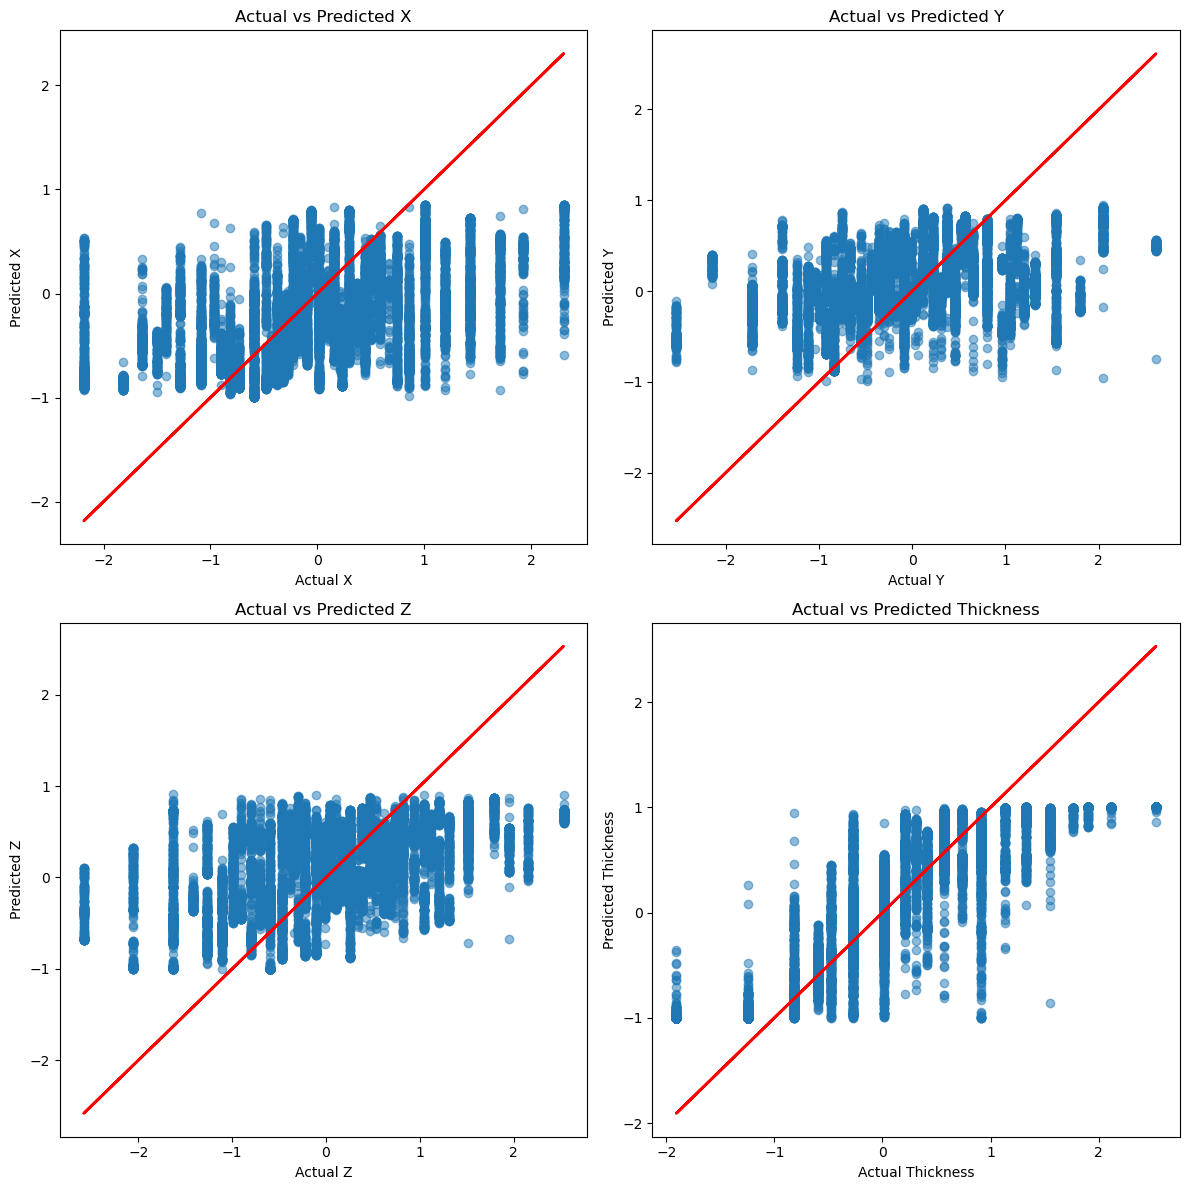

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

targets = ['X', 'Y', 'Z', 'Thickness']

for i, target in enumerate(targets):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(y_test[target], y_pred_test[:, i], alpha=0.5)
    axes[row, col].plot(y_test[target], y_test[target], color='red', linewidth=2)
    axes[row, col].set_xlabel("Actual " + target)
    axes[row, col].set_ylabel("Predicted " + target)
    axes[row, col].set_title("Actual vs Predicted " + target)

plt.tight_layout()
plt.show()

# Residual Plots

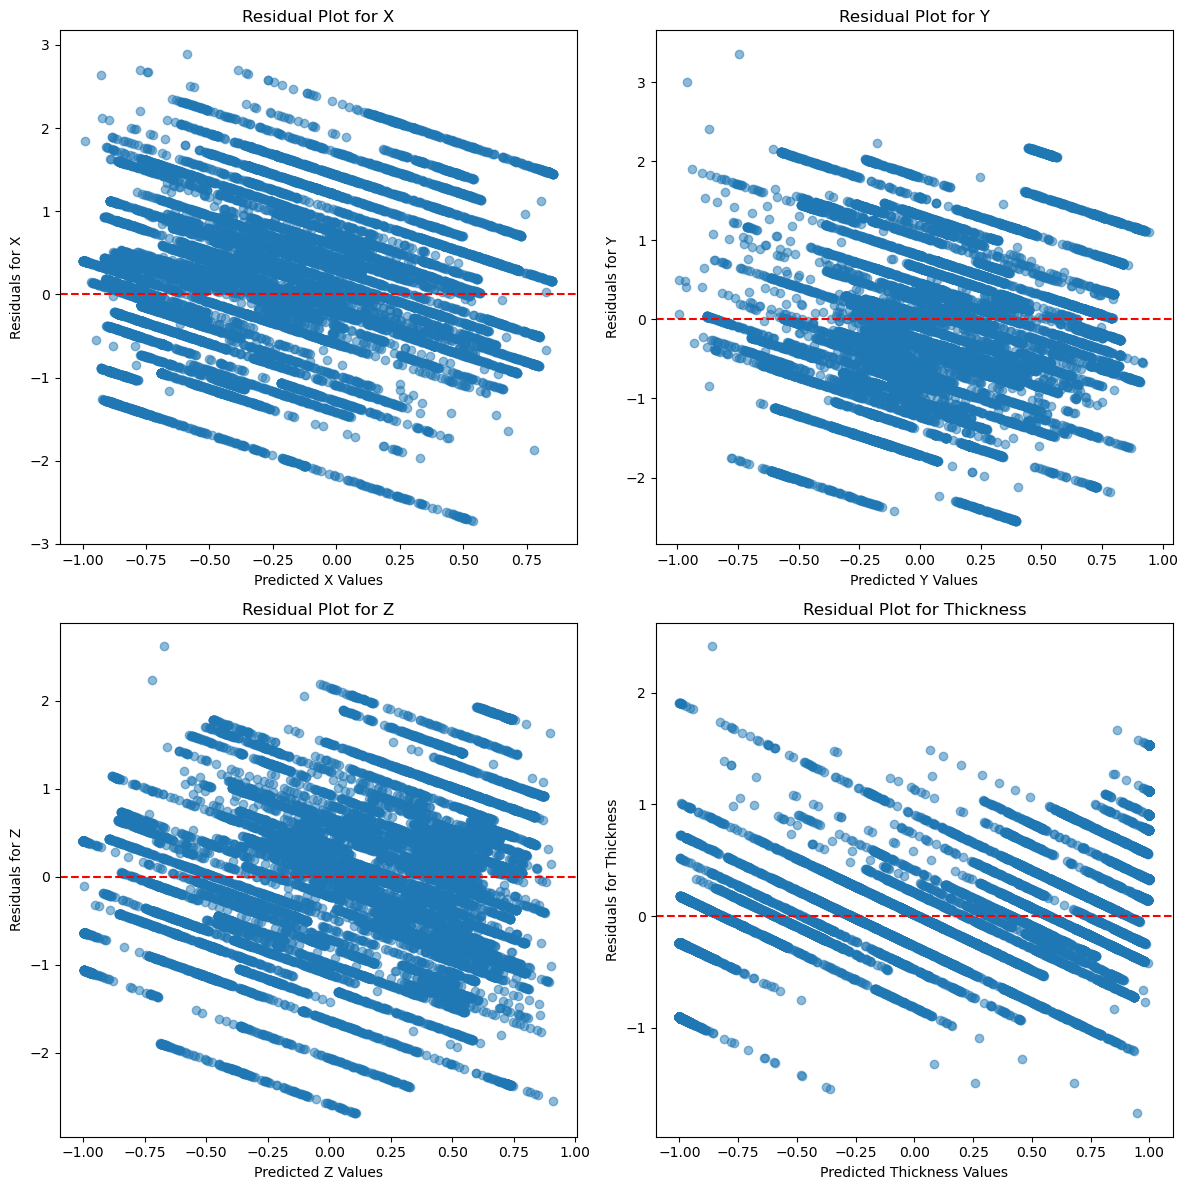

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

residuals = [y_test[target] - y_pred_test[:, idx] for idx, target in enumerate(targets)]

for idx, ax in enumerate(axes):
    ax.scatter(y_pred_test[:, idx], residuals[idx], alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel(f'Predicted {targets[idx]} Values')
    ax.set_ylabel(f'Residuals for {targets[idx]}')
    ax.set_title(f'Residual Plot for {targets[idx]}')

plt.tight_layout()
plt.show()
